# and now for something completely different...

### During these excersizes, we have seen a traditional parameter estimation then uncertainty analysis workflow.  We also saw for the pilot points notebooks, about 500 model runs to "calibrate" the model and then another 500 to 1000 to find a decent set (ensemble) of realizations that fit the data acceptably well.  

### But...even using pilot points as a parameterization device is a form of regularization: ideally, we would have an HK parameter in every model cell. But, that is too expensive in terms of model runs for calibration and uncertainty analysis (at least as we have learned it so far).

### However, there are some new techniques that free us from these computational constraints so that we can more efficiently use lots of parameters.  One approach to this is the iterative Ensemble Smoother form of the GLM.  Let's see how this technique works for the freyberg model - a special version of the freyberg model with an HK, and recharge parameter in every cell.

In [1]:
%matplotlib inline
import os, shutil
import sys
sys.path.append("..")
import numpy as np
from IPython.display import Image
import pandas as pd
import matplotlib.pyplot as plt

import flopy as flopy
import pyemu

In [2]:
import freyberg_setup as fs
fs.setup_pest_gr()
working_dir = fs.WORKING_DIR_GR
pst_name = fs.PST_NAME_GR

****Warning -- two packages of the same type:  <class 'flopy.modflow.mfbas.ModflowBas'> <class 'flopy.modflow.mfbas.ModflowBas'>
replacing existing Package...

changing model workspace...
   freyberg_gr
FloPy is using the following executable to run the model: /Users/jeremyw/Dev/gw1876/activities/freyberg_grid_ies/freyberg_gr/mfnwt

                                  MODFLOW-NWT-SWR1 
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUNDWATER-FLOW MODEL
                             WITH NEWTON FORMULATION
                             Version 1.1.1, 7/21/2016                        
                    BASED ON MODFLOW-2005 Version 1.11.0 08/08/2013                       

                    SWR1 Version 1.04.0 07/21/2016                       

 Using NAME file: freyberg.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2018/03/21 14:00:01

 Solving:  Stress period:     1    Time step:     1    Groundwater-Flow Eqn.
 Solving:  Stress period:     2    Time step:     1    Ground

In [4]:
m = flopy.modflow.Modflow.load(fs.MODEL_NAM,model_ws=working_dir,load_only=["upw"],check=False)
pst = pyemu.Pst(os.path.join(working_dir,pst_name))
obs = pst.observation_data
#obs.loc[obs.obgnme=="calhead","weight"] = 0.75
par = pst.parameter_data

grid_groups = []
grid_prefixes = ['hk','r0','r1','ss','sy']
for prefix in grid_prefixes:
    gr_par = par.loc[par.pargp==prefix].copy()
    gr_par.loc[:,"i"] = gr_par.parnme.apply(lambda x: int(x.split('_')[1][1:]))
    gr_par.loc[:,"j"] = gr_par.parnme.apply(lambda x: int(x.split('_')[2][1:]))
    gr_par.loc[:,"x"] = m.sr.xcentergrid[gr_par.i,gr_par.j]
    gr_par.loc[:,"y"] = m.sr.ycentergrid[gr_par.i,gr_par.j]
    grid_groups.append(gr_par)


In [5]:
"number of parameters: {0} : WTF!".format(pst.npar)

'number of parameters: 4013 : WTF!'

building diagonal cov
processing  name:struct1,nugget:0.0,structures:
name:var1,contribution:1.0,a:2500.0,anisotropy:1.0,bearing:0.0

build cov matrix
done
getting diag var cov 800
scaling full cov by diag var cov
test for inversion
replace in full cov
allocating other_x
replacing
build cov matrix
done
getting diag var cov 800
scaling full cov by diag var cov
test for inversion
replace in full cov
allocating other_x
replacing
build cov matrix
done
getting diag var cov 800
scaling full cov by diag var cov
test for inversion
replace in full cov
allocating other_x
replacing
build cov matrix
done
getting diag var cov 800
scaling full cov by diag var cov
test for inversion
replace in full cov
allocating other_x
replacing
build cov matrix
done
getting diag var cov 800
scaling full cov by diag var cov
test for inversion
replace in full cov
allocating other_x
replacing


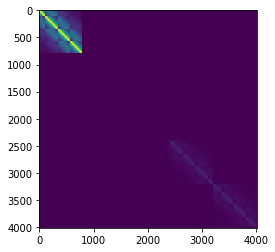

In [8]:
v = pyemu.geostats.ExpVario(contribution=1.0,a=2500.0)
gs = pyemu.geostats.GeoStruct(variograms=v)
cov = pyemu.helpers.geostatistical_prior_builder(pst=pst,struct_dict={gs:grid_groups},sigma_range=6)
cov.to_ascii(os.path.join(working_dir,"prior.cov"))
plt.imshow(cov.x)

### run pestpp-ies

In [9]:
pst.pestpp_options = {}
pst.pestpp_options["ies_subset_size"] = 8
pst.pestpp_options["ies_lambda_mults"] = [0.1,1.0,10.0]
pst.pestpp_options['par_sigma_range'] = 6
pst.pestpp_options["parcov_filename"] = "prior.cov"
pst.control_data.noptmax = 4
pst.write(os.path.join(working_dir,pst_name))

In [10]:
pyemu.helpers.start_slaves(working_dir,"pestpp-ies",pst_name,num_slaves=15,master_dir="master")

In [ ]:
par = pd.read_csv(os.path.join("master",pst_name.replace(".pst",".0.par.csv")),index_col=0)
par.columns = par.columns.map(str.lower)

In [ ]:
pyemu.plot_utils.ensemble_helper(par.iloc[:,:10])

In [ ]:
for i in range(10):
    